In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

# !wget -O selected.zip https://www.dropbox.com/s/ow1delunc6sb5if/selected.zip?dl=1
# !unzip selected.zip
!wget -O parrington.zip https://www.dropbox.com/s/aa59g3j160e0qec/parrington.zip?dl=1
!unzip parrington.zip

--2022-04-27 11:53:51--  https://www.dropbox.com/s/aa59g3j160e0qec/parrington.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/aa59g3j160e0qec/parrington.zip [following]
--2022-04-27 11:53:51--  https://www.dropbox.com/s/dl/aa59g3j160e0qec/parrington.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc825cd88e3bffea3ec7ed14aeaa.dl.dropboxusercontent.com/cd/0/get/BkOBXciA3bEm7E3j_bO-JX4pEn43XqIfTav9S-DXPm8gby7WPxeDsXYVqy4sGEiu29XiFkwcPhym_S7tEDTtO9VK2gm4tRX15Y38WGWoRn8M_ZuU4_1fBwrbCKllC4crc712Jac7QP1N1tkgoLiSg0e4JkrFWQKwzIa3bd4Z6H_S7U0H16qyVmxrYXKA4v_y530/file?dl=1# [following]
--2022-04-27 11:53:51--  https://uc825cd88e3bffea3ec7ed14aeaa.dl.dropboxusercontent.com/cd/0/get/BkOBXciA3bEm7E3j_bO-JX4pEn43XqIfTav9S-D

In [ ]:
import os
import numpy as np
import cv2 as cv
from scipy.spatial import KDTree
import random
from matplotlib import pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm

In [ ]:
def cylindrical_warp(src, f):
  map_x = np.zeros((src.shape[0], src.shape[1]), dtype=np.float32)
  map_y = np.zeros((src.shape[0], src.shape[1]), dtype=np.float32)
  c = [ src.shape[0] / 2.0, src.shape[1] / 2.0 ]
  f2 = f ** 2
  for i in range(src.shape[0]):
    for j in range(src.shape[1]):
      map_x[i][j] = f * np.tan( 1.0 * (j - c[1]) / f ) + c[1]
      map_y[i][j] = 1.0 * (i - c[0]) / f * np.sqrt( (map_x[i][j] - c[1])**2 + f2 ) + c[0]
  warp = cv.remap(src, map_x, map_y, cv.INTER_LINEAR,	borderMode = cv.BORDER_CONSTANT)
  # cmp = np.concatenate((src, warp), axis=1)
  # plt.imshow(np.array(cmp).astype('uint8'))
  # print(map_x)
  # print(map_y)
  return warp

In [ ]:
def match_feat(kp_tar, des_tar, kp_src, des_src):
  tree = [KDTree(des_tar), KDTree(des_src)]
  match = [[], []]
  
  for point in tqdm(des_src):
    dist0, ind0 = tree[0].query(point, k=2)
    if dist0[0] / dist0[1] > 0.7:
      continue
    dist0, ind0 = dist0[0], ind0[0]
    dist1, ind1 = tree[1].query(des_tar[ind0], k=1)
    if des_src[ind1][0] == point[0] and des_src[ind1][1] == point[1]:
      match[0].append( kp_tar[ind0].pt )
      match[1].append( kp_src[ind1].pt )
  print(len(match[1]))
  # for i in (0,1):
  #   cv.drawKeypoints(img[i], match[i], img[i])
  #   cv.imwrite('sift_keypoints'+ str(i) +'.jpg', img[i])
  return np.array(match[0]), np.array(match[1])

# p1, p2 = match_feat(kp[15:17], des[15:17])

100%|██████████| 6347/6347 [09:03<00:00, 11.67it/s]

567


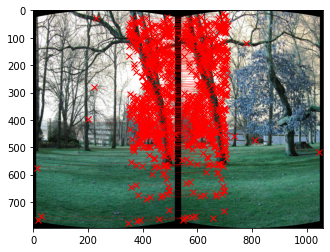

In [ ]:
def plot_matches(p1, p2, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type
    
    ax.plot(p1[:, 0], p1[:, 1], 'xr')
    ax.plot(p2[:, 0] + offset, p2[:, 1], 'xr')
     
    ax.plot([p1[:, 0], p2[:, 0] + offset], [p1[:, 1], p2[:, 1]],
            'r', linewidth=0.1)

    plt.show()

# total_img = np.concatenate((img[16], img[15]), axis=1)
# plot_matches(p2, p1, total_img)

In [141]:
def homography(p1, p2):
  rows = []
  for a, b in zip(p1, p2):
    row1 = [0, 0, 0, b[0], b[1], 1, -a[1]*b[0], -a[1]*b[1], -a[1]]
    row2 = [b[0], b[1], 1, 0, 0, 0, -a[0]*b[0], -a[0]*b[1], -a[0]]
    rows.append(row1)
    rows.append(row2)
  rows = np.array(rows)
  U, s, V = np.linalg.svd(rows)
  H = V[-1].reshape(3, 3)
  H = H/H[2, 2] # standardize to let w*H[2,2] = 1
  return H
def cylin_affine(p1, p2):
  A = np.zeros( (p1.shape[0] * 2, 6) )
  B = np.zeros( (p1.shape[0] * 2, 1) )
  ind = 0
  A_rows = []
  B_rows = []
  for a, b in zip(p1, p2):
    row1 = [1, 0, b[0], b[1], 0, 0]
    row2 = [0, 1, 0, 0, b[0], b[1]]
    A_rows.append(row1)
    A_rows.append(row2)
    B_rows.append( [a[0]] )
    B_rows.append( [a[1]] )
  A = np.array(A_rows)
  B = np.array(B_rows)
  cyl_aff , _, _, _ = np.linalg.lstsq(A, B, rcond=-1)
  cyl_aff = np.array( [[ cyl_aff[2], cyl_aff[3], cyl_aff[0] ], [ cyl_aff[4], cyl_aff[5], cyl_aff[1]]] ).squeeze()
  return cyl_aff

def ransac(tar, src, thresh = 5, k = 4, iter = 1000, method = "affine"):
  max_match = 0
  all_match = []
  best_match_pairs = [[], []]
  best_trans = None
  for i in tqdm(range(iter)):
    match = 0
    match_pairs = [[],[]]
    sam = random.sample( range(src.shape[0]), k )

    if method == "homography":
      H = homography( tar[sam], src[sam] )
    elif method == "affine":
      A = cylin_affine( tar[sam], src[sam] )

    # # check rank 
    # if np.linalg.matrix_rank(H) < 3:
    #   continue
    for i in range(src.shape[0]):
      p = np.append(src[i], 1)
      if method == "homography":
        pred = np.dot(H, p)
        pred = np.array( [ pred[0]/pred[2], pred[1]/pred[2] ])
      elif method == "affine":
        pred = np.dot(A, p)
      # print(pred)
      if np.linalg.norm(pred - tar[i], ord = 2) < thresh:
        match += 1
        match_pairs[0].append(tar[i])
        match_pairs[1].append(src[i])
    all_match.append(match)
    if match > max_match:
      max_match = match
      best_match_pairs = match_pairs
      if method == "homography":
        best_trans = H.copy()
      elif method == "affine":
        best_trans = A.copy()
    
  print("Inliers / Total pairs:", max_match, "/", src.shape[0], "(", max_match/src.shape[0], ")")
  print(sorted(all_match, reverse=True))
  return best_trans, np.array(best_match_pairs)

# A, pairs = ransac(p2, p1)

# total_img = np.concatenate((img[16], img[15]), axis=1)
# plot_matches(pairs[0], pairs[1], total_img)

Inliers / Total pairs: 482 / 567 ( 0.8500881834215167 )
[482, 481, 481, 479, 479, 478, 478, 477, 477, 475, 475, 475, 474, 473, 473, 473, 473, 472, 472, 472, 472, 471, 471, 470, 470, 470, 469, 469, 469, 469, 469, 468, 468, 468, 468, 467, 467, 467, 467, 466, 466, 466, 466, 466, 466, 466, 465, 465, 465, 465, 464, 464, 463, 463, 463, 463, 463, 463, 463, 463, 462, 462, 462, 462, 461, 461, 461, 461, 460, 460, 460, 460, 460, 460, 460, 459, 458, 458, 458, 458, 458, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 457, 456, 456, 456, 456, 456, 456, 455, 455, 454, 454, 454, 454, 454, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 452, 452, 452, 452, 452, 451, 451, 451, 451, 451, 451, 451, 451, 451, 450, 450, 450, 450, 450, 449, 449, 449, 449, 449, 449, 449, 448, 448, 448, 448, 448, 448, 448, 447, 447, 447, 447, 447, 447, 446, 446, 446, 446, 446, 446, 445, 445, 445, 445, 445, 445, 444, 444, 444, 443, 443, 443, 443, 443, 442, 442, 442, 442, 442, 442, 442, 442, 441

100%|██████████| 808/808 [00:10<00:00, 74.70it/s]


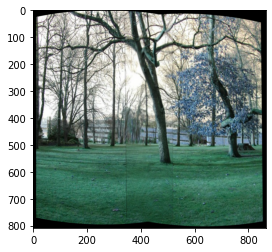

In [155]:
def stitch_img(img1, img2, trans):
  # stitch img2 to img1
  # img1 = cv.normalize(img1.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
  # img2 = cv.normalize(img2.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
  corners = np.array([[0, 0, 1], [0, img2.shape[0], 1], [img2.shape[1], 0, 1], [img2.shape[1], img2.shape[0], 1]]).T
  # print(corners)

  # find corners of the warped image
  mapped_corners = np.dot(trans, corners).T.astype("int32")
  # mapped_corners = mapped_corners / mapped_corners[2, :]
  # mapped_corners = mapped_corners[:-1, :].T.astype("int32")
  # print(mapped_corners)

  # shift the warpped image downwards if the transformed y coordinate is a negative value
  min_v = min(0, min(mapped_corners[:,1]))
  trans_new = trans.copy()
  trans_new[1, 2] += abs(min_v)
  
  new_corners = np.zeros( (2,2) )
  new_corners[0] = np.array( [ min( 0, min(mapped_corners[:, 0])), min( 0, min(mapped_corners[:, 1])) ] )
  new_corners[1] = np.array( [ max( img1.shape[0], max(mapped_corners[:, 0])), max( img1.shape[1], max(mapped_corners[:, 1])) ] )
  new_corners = new_corners.astype("int32")
  # print(new_corners)

  # shift the base image downwards if the transformed y coordinate is a negative value
  top_pad = np.zeros( ( abs(min_v), img1.shape[1], 3 ) )
  bot_pad = np.zeros( (max(0, new_corners[1][0] - img1.shape[0]), img1.shape[1], 3 ) )
  right_pad = np.zeros( ( new_corners[1][0], new_corners[1][0] - img1.shape[1], 3) )
  # print(top_pad.shape, bot_pad.shape)

  warped_l = np.concatenate( (top_pad, img1, bot_pad), axis=0 )
  warped_l = np.concatenate( (warped_l, right_pad), axis=1 ).astype('uint32')
  # print(warped_l.shape)
  # cv.imwrite('warped_l.jpg', np.array(warped_l))

  

  w, h = round( new_corners[1][0] - new_corners[0][0] ), round( new_corners[1][1] - new_corners[0][1] )
  
  # warped = cv.warpPerspective(src = img2, M = trans_new, dsize = ( w, h ) )
  warped_r = cv.warpAffine(src = img2, M = trans_new, dsize = (w, h)).astype('uint32')

  # print(warped_r.shape)
  # fig, ax = plt.subplots()
  # ax.imshow(np.array(warped_r))
  
  # cv.imwrite('warped_r.jpg', np.array(warped_r))

  black = np.zeros(3)  # Black pixel.
  # Stitching procedure, store results in warped_l.
  for i in tqdm(range(warped_r.shape[0])):
      for j in range(warped_r.shape[1]):
          pixel_l = warped_l[i, j, :]
          pixel_r = warped_r[i, j, :]
          
          if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
              warped_l[i, j, :] = pixel_l
          elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
              warped_l[i, j, :] = pixel_r
          elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
              warped_l[i, j, :] = (pixel_l + pixel_r) / 2
          else:
              pass
                
  stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :].astype("uint8")
  return stitch_image

# stitched = stitch_img(img[16], img[15], A)
# plt.imshow(stitched)

In [ ]:
# assume we can get the focal length estimate
focal = []
with open(os.path.join("parrington", "pano.txt")) as f:
  ind = 1
  for line in f:
    if ind % 13 == 12:
      focal.append(float(line))
    ind += 1
print(focal)

fns = sorted(glob.glob(os.path.join("parrington","prtn*.jpg")))
print(fns)
img = []
kp, des = [], []
pre, cur = None, None
# dim = (795, 530)

class Partial_img:
  def __init__(self, img = None, kp = None, des = None):
    self.img = img
    self.kp = kp
    self.des = des
panorama = None
for i in range(len(fns)-1, -1, -1):
  # tmp = cv.resize(cv.imread(fns[i]), (dim[1], dim[0]))
  img = cv.imread(fns[i])
  img = cylindrical_warp(img, focal[i])
  # img.append(tmp)
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create()
  k, d = sift.detectAndCompute(gray, None)
  d = np.array(d)
  # kp.append(k)
  # des.append( np.array(d) )
  cur = Partial_img(img, k, d)
  print( fns[i], "keypoint num:", len(k))
  if i == len(fns)-1:
    pre, cur = cur, None
    continue
  p_pre, p_cur = match_feat(pre.kp, pre.des, cur.kp, cur.des)
  A, pairs = ransac(p_pre, p_cur)


  pre, cur = cur, None
img = np.array(img)
